In [ ]:
! pip install tensorflow_addons
! pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.0 MB/s eta 0:00:00


In [ ]:
!mkdir input

In [ ]:
import os
import random
import warnings
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay
)
from scikitplot.metrics import plot_roc

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign #veri setinin buraya yapıştır


In [ ]:
# Mute warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
plt.style.use("dark_background")

In [ ]:
# View package versions
versions = {
    'package': [
        'pandas', 'numpy',
        'sklearn', 'seaborn',
        'tensorflow', 'tensorflow_addons',
        ],
    'version': [
        pd.__version__, np.__version__,
        sklearn.__version__, sns.__version__,
        tf.__version__, tfa.__version__,
        ],
}

print('Package versions:')
print('-----------------')
ver_df = pd.DataFrame(versions)
ver_df

Package versions:
-----------------


package version
0             pandas   2.0.3
1              numpy  1.25.2
2            sklearn   1.2.2
3            seaborn  0.13.1
4         tensorflow  2.15.0
5  tensorflow_addons  0.23.0

In [ ]:
class CFG:
    POSITIONAL_EMBEDDING = True
    TOKENIZER_CONV_LAYERS = 2
    PROJECTION_DIM = 128
    NUM_HEADS = 2

    TRANSFORMER_UNITS = [
        PROJECTION_DIM,
        PROJECTION_DIM,
    ]

    TRANSFORMER_LAYERS = 4
    STOCHASTIC_DEPTH_RATE = 0.1
    NUM_CLASSES = 2

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.0001
    EPOCHS = 10
    BATCH_SIZE = 64
    SEED = 42
    TF_SEED = 768

    #######################################################
    # Note: If you wish to increase the image size beyond #
    #       the current value, make sure you have access  #
    #       to enough memory.                             #
    #######################################################
    HEIGHT = 144
    WIDTH = 144
    CHANNELS = 3
    IMAGE_SIZE = 144
    IMAGE_SHAPE = (144, 144, 3)

    # Define paths
    DATASET_PATH = "/content/input/skin-cancer-malignant-vs-benign/"
    TRAIN_PATH = '/content/input/skin-cancer-malignant-vs-benign/train/'
    TEST_PATH = '/content/input/skin-cancer-malignant-vs-benign/test/'

In [ ]:
# Generate a summary of the dataset
print('DATASET SUMMARY')
print('========================\n')
for dirpath, dirnames, filenames in os.walk(CFG.DATASET_PATH):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
print('\n========================')

DATASET SUMMARY

There are 2 directories and 0 images in /content/input/skin-cancer-malignant-vs-benign/
There are 2 directories and 0 images in /content/input/skin-cancer-malignant-vs-benign/test
There are 0 directories and 360 images in /content/input/skin-cancer-malignant-vs-benign/test/benign
There are 0 directories and 300 images in /content/input/skin-cancer-malignant-vs-benign/test/malignant
There are 2 directories and 0 images in /content/input/skin-cancer-malignant-vs-benign/train
There are 0 directories and 1440 images in /content/input/skin-cancer-malignant-vs-benign/train/benign
There are 0 directories and 1197 images in /content/input/skin-cancer-malignant-vs-benign/train/malignant



In [ ]:
%%time
train_images = glob.glob(f"{CFG.TRAIN_PATH}**/*.jpg")
test_images = glob.glob(f"{CFG.TEST_PATH}**/*.jpg")

CPU times: user 9.18 ms, sys: 729 µs, total: 9.91 ms
Wall time: 10.2 ms


In [ ]:
# Get train & test set sizes
train_size = len(train_images)
test_size = len(test_images)

# Get dataset size
total = train_size + test_size

# View samples counts
print(f'train samples count:\t\t{train_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		2637
test samples count:		660
TOTAL:				3297


In [ ]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })

    # Generate label encodings
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'malignant' else 1, axis=1)

    # Shuffle and return df
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [ ]:
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))

In [ ]:
# View first 5 samples in the training set
train_df.head(5)

image_path      label  label_encoded
0  /content/input/skin-cancer-malignant-vs-benign...  malignant              0
1  /content/input/skin-cancer-malignant-vs-benign...     benign              1
2  /content/input/skin-cancer-malignant-vs-benign...     benign              1
3  /content/input/skin-cancer-malignant-vs-benign...     benign              1
4  /content/input/skin-cancer-malignant-vs-benign...  malignant              0

In [ ]:
def _load(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)

    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS5)

    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.

    # Return image
    return image

def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)

    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)

    plt.title(f'Label: {label}', fontsize=16)
    return

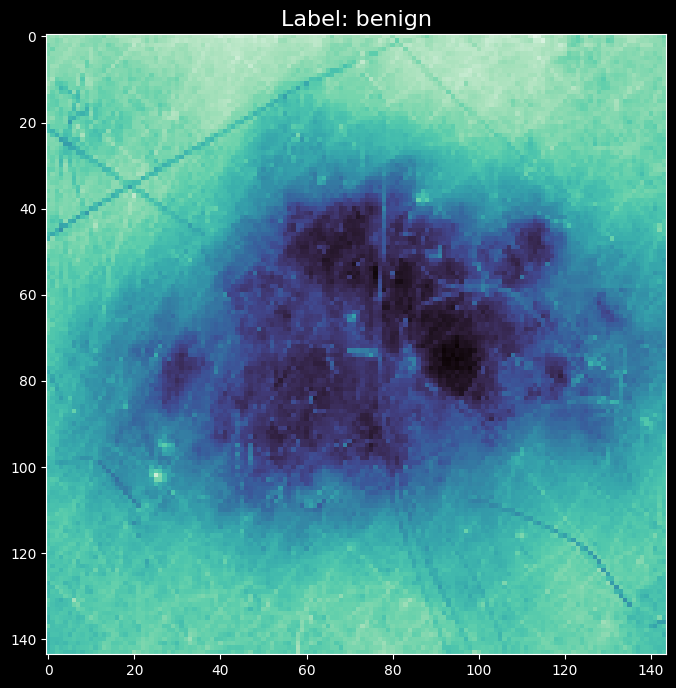

In [ ]:
# Select random sample from train_df
idx = random.sample(train_df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]

# View the random sample
view_sample(sample_image, sample_label, color_map='mako')

In [ ]:
def view_multiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1

    idx = random.sample(df.index.to_list(), count)
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}', pad=20, fontsize=16)

        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]))
        else:
            plt.imshow(
                tf.image.rgb_to_grayscale(
                    sample_loader(df.image_path[_])),
                cmap=color_map
            )

        # Remove x & y ticks
        plt.xticks([])
        plt.yticks([])

    return

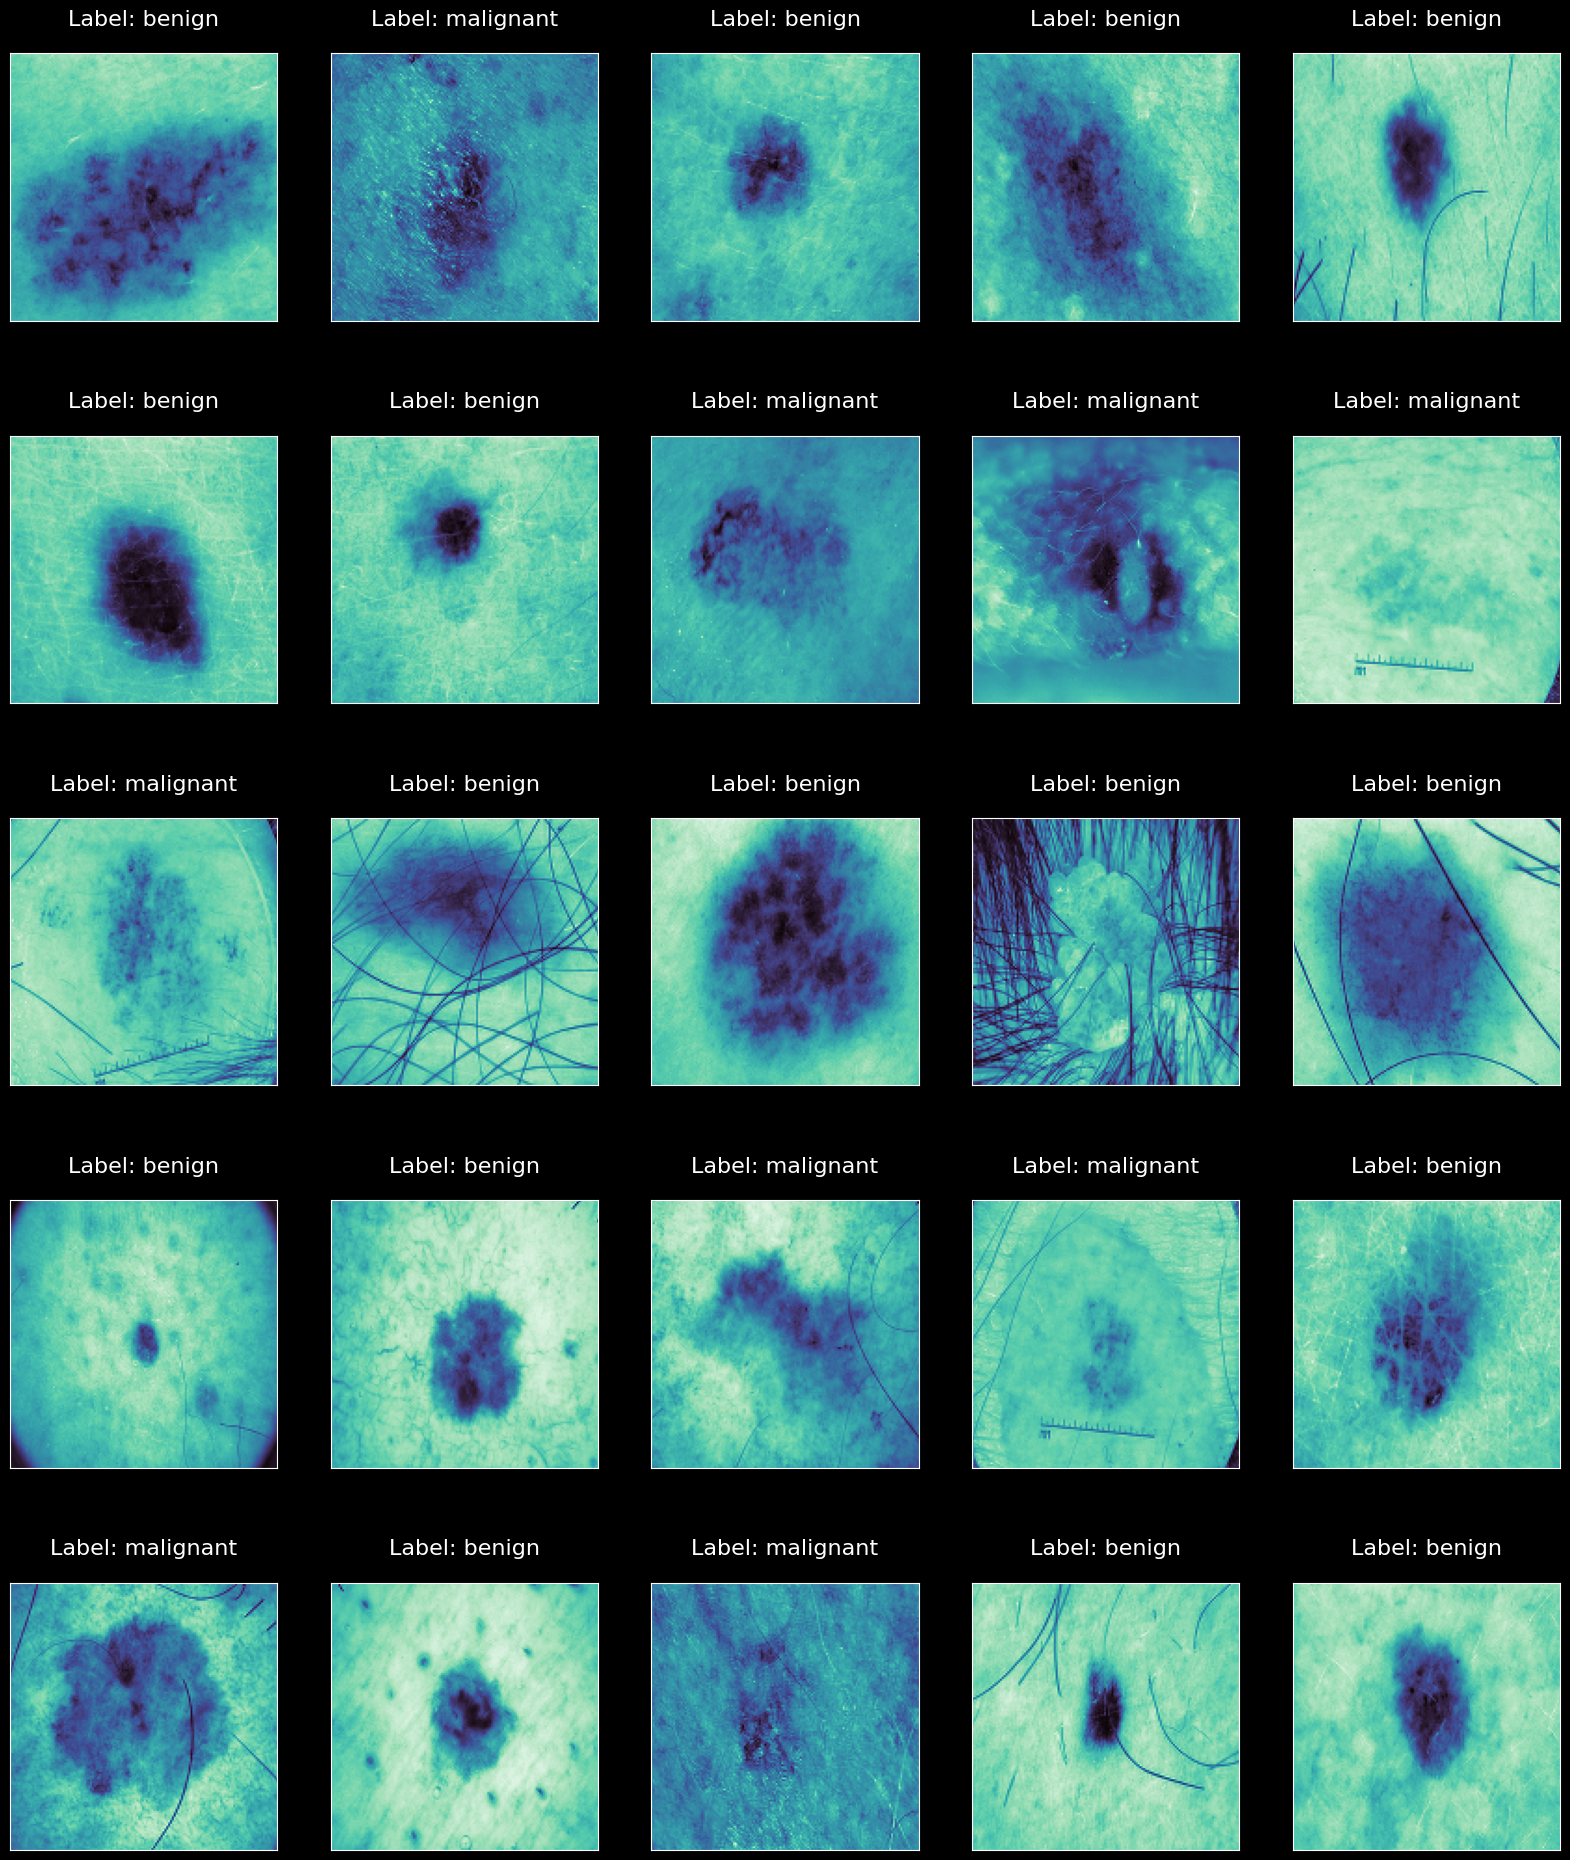

In [ ]:
view_multiple_samples(
    train_df,
    _load,
    count=25,
    color_map='mako',
    fig_size=(20, 24)
)

<ipython-input-19-91d7e80751d6>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot1 = sns.barplot(
<ipython-input-19-91d7e80751d6>:9: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bar_plot1 = sns.barplot(
<ipython-input-19-91d7e80751d6>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot2 = sns.barplot(
<ipython-input-19-91d7e80751d6>:22: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bar_plot2 = sns.barplot(


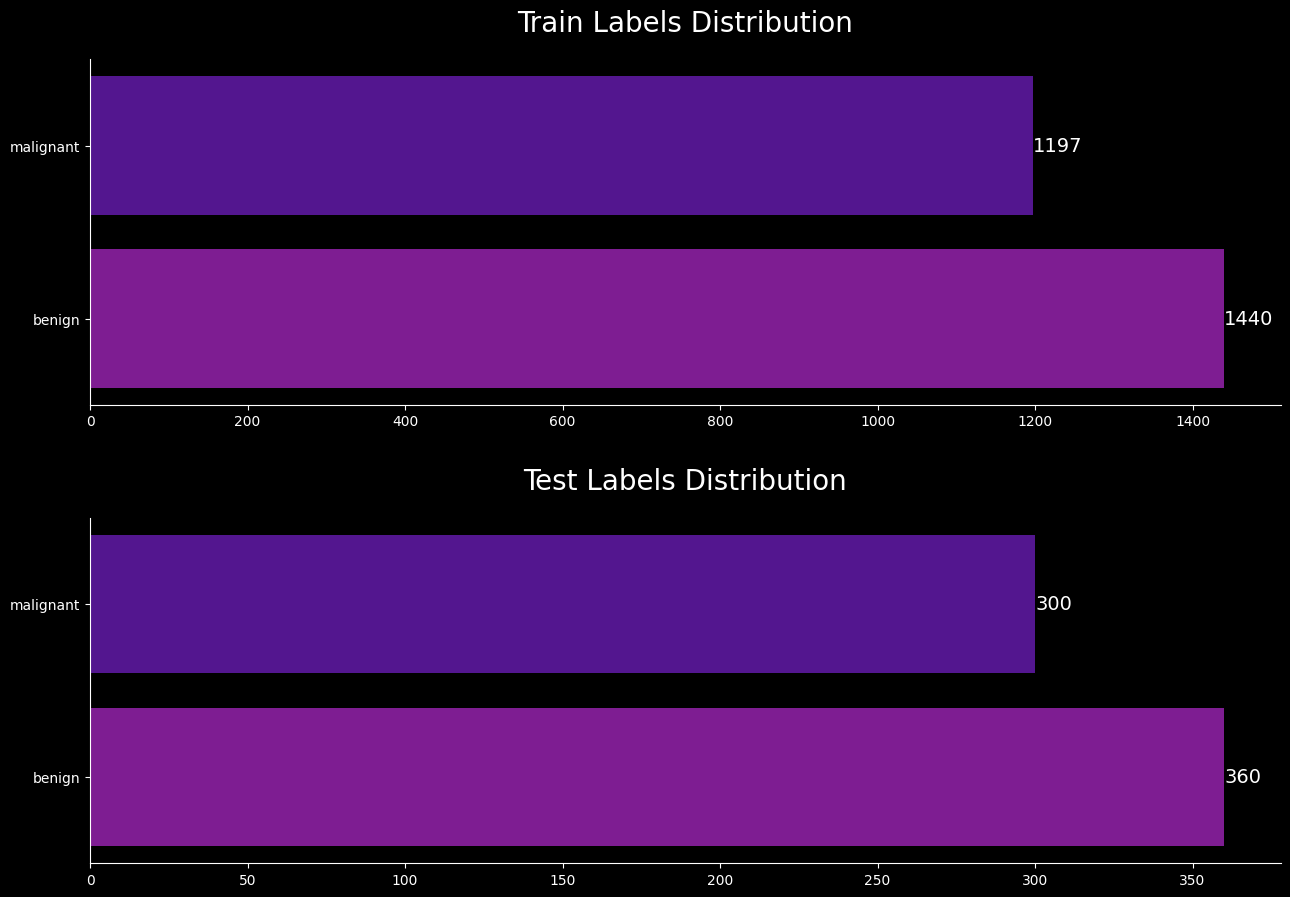

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20, pad=20)
train_distribution = train_df['label'].value_counts().sort_values()
bar_plot1 = sns.barplot(
    x=train_distribution.values,
    y=list(train_distribution.keys()),
    orient="h", palette=sns.color_palette("plasma"),
    ax=ax1
);

for container in bar_plot1.containers:
    bar_plot1.bar_label(container, fmt='%.0f', fontsize=14);

# Plot Test Labels Distribution
ax2.set_title('Test Labels Distribution', fontsize=20, pad=20)
test_distribution = test_df['label'].value_counts().sort_values()
bar_plot2 = sns.barplot(
    x=test_distribution.values,
    y=list(test_distribution.keys()),
    orient="h", palette=sns.color_palette("plasma"),
    ax=ax2
);
for container in bar_plot2.containers:
    bar_plot2.bar_label(container, fmt='%.0f', fontsize=14);

sns.despine();

In [ ]:
# Create Train/Val split with Training Set
train_split_idx, val_split_idx, _, _ = train_test_split(
    train_df.index,
    train_df.label_encoded,
    test_size=0.15,
    stratify=train_df.label_encoded,
    random_state=CFG.SEED
)

In [ ]:
# Get new training and validation data
train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)

# View shapes
train_new_df.shape, val_df.shape

((2241, 3), (396, 3))

<ipython-input-22-1a5734f5a194>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot1 = sns.barplot(
<ipython-input-22-1a5734f5a194>:9: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bar_plot1 = sns.barplot(
<ipython-input-22-1a5734f5a194>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot2 = sns.barplot(
<ipython-input-22-1a5734f5a194>:22: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  bar_plot2 = sns.barplot(


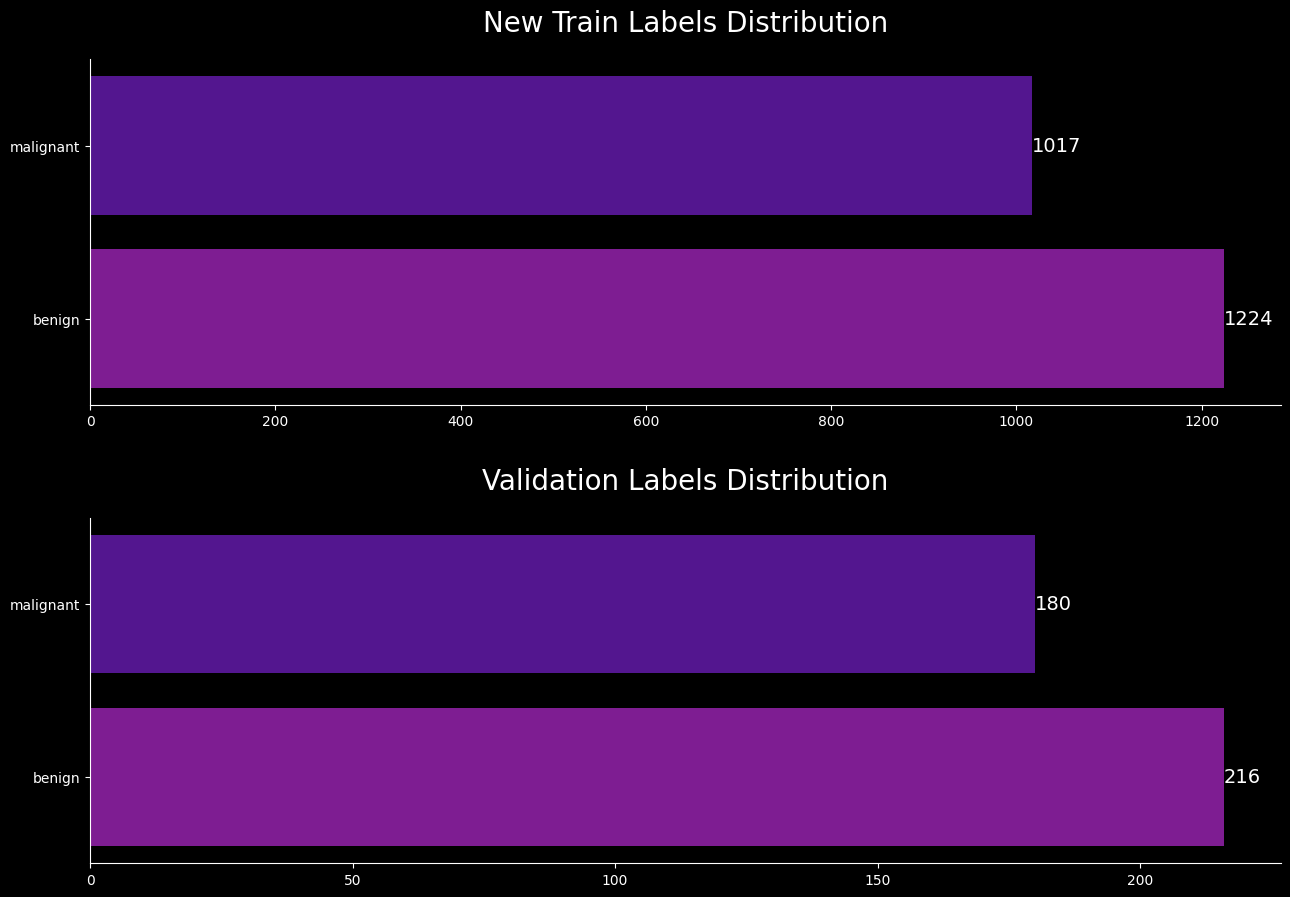

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot New Train Labels Distribution
ax1.set_title('New Train Labels Distribution', fontsize=20, pad=20)
train_new_distribution = train_new_df['label'].value_counts().sort_values()
bar_plot1 = sns.barplot(
    x=train_new_distribution.values,
    y=list(train_new_distribution.keys()),
    orient="h", palette=sns.color_palette("plasma"),
    ax=ax1
);

for container in bar_plot1.containers:
    bar_plot1.bar_label(container, fmt='%.0f', fontsize=14);

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=20, pad=20)
val_distribution = val_df['label'].value_counts().sort_values()
bar_plot2 = sns.barplot(
    x=val_distribution.values,
    y=list(val_distribution.keys()),
    orient="h", palette=sns.color_palette("plasma"),
    ax=ax2
);

for container in bar_plot2.containers:
    bar_plot2.bar_label(container, fmt='%.0f', fontsize=14);

sns.despine();

In [ ]:
# Build augmentation layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
], name='augmentation_layer')

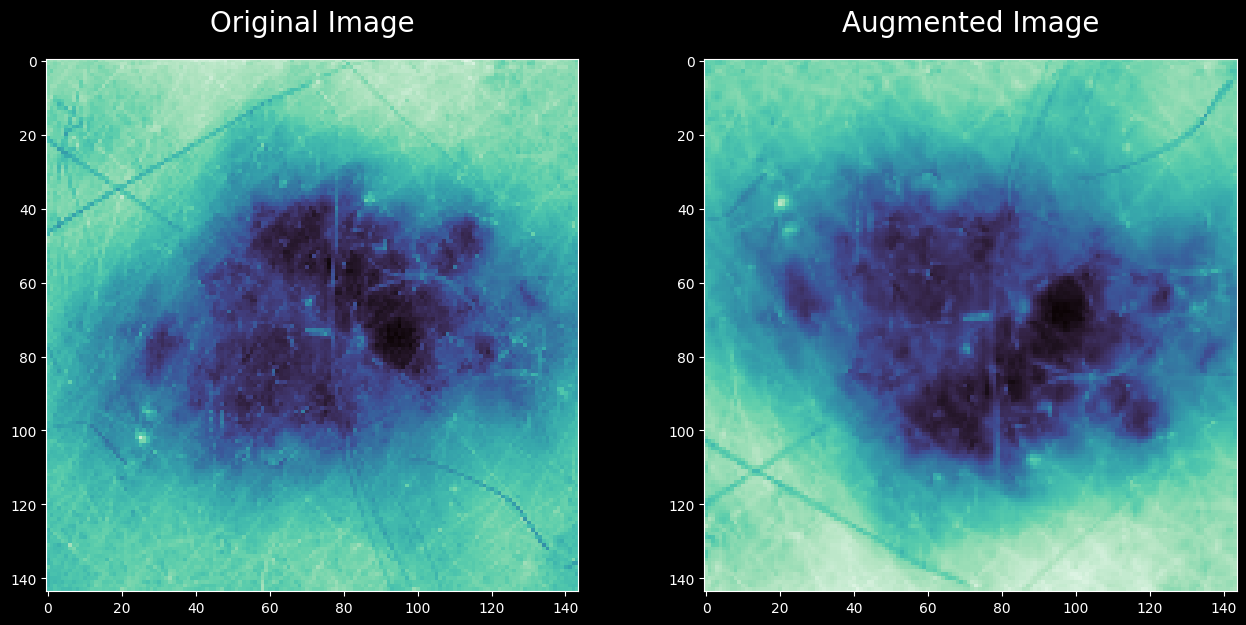

In [ ]:
image = tf.image.rgb_to_grayscale(sample_image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20, pad=20)
ax1.imshow(image, cmap='mako');

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20, pad=20)
ax2.imshow(augmentation_layer(image), cmap='mako');

In [ ]:
def encode_labels(labels, encode_depth=2):
    return tf.one_hot(labels, depth=encode_depth).numpy()

def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    '''
    Generates an input pipeline using the tf.data API given a Pandas DataFrame and image loading function.

    @params
        - df: (pd.DataFrame) -> DataFrame containing paths and labels
        - load_function: (function) -> function used to load images given their paths
        - augment: (bool) -> condition for applying augmentation
        - batch_size: (int) -> size for batched (default=32)
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (str) -> cache path for caching data, data is not cached when None (default=None)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)

    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    # Get image paths and labels from DataFrame
    image_paths = df.image_path
    image_labels = encode_labels(df.label_encoded)
    AUTOTUNE = tf.data.AUTOTUNE

    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

    # Map augmentation layer and load function to dataset inputs if augment is True
    # Else map only the load function
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)

    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    # Apply batching
    ds = ds.batch(batch_size)

    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)

    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    # Return the dataset
    return ds

In [ ]:
# Generate Train Input Pipeline
train_ds = create_pipeline(train_new_df, _load, augment=True,
                           batch_size=CFG.BATCH_SIZE,
                           shuffle=False, prefetch=True)

# Generate Validation Input Pipeline
val_ds = create_pipeline(val_df, _load,
                         batch_size=CFG.BATCH_SIZE,
                         shuffle=False, prefetch=False)

# Generate Test Input Pipeline
test_ds = create_pipeline(test_df, _load,
                          batch_size=CFG.BATCH_SIZE,
                          shuffle=False, prefetch=False)

In [ ]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 144, 144, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 144, 144, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
Test Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 144, 144, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


In [ ]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=2,
        num_output_channels=[64, 128],
        positional_embedding=True,
        **kwargs,
    ):
        # Initialize tokenizer
        super(CCTTokenizer, self).__init__(**kwargs)
        self.tokenizer = Sequential()

        for _ in range(num_conv_layers):
            # Add Conv Layer
            self.tokenizer.add(
                layers.Conv2D(
                    num_output_channels[_],
                    kernel_size, stride,
                    padding="valid", use_bias=False,
                    activation="relu",kernel_initializer="he_normal",
                    name=f'tokenizer_conv_{_}'
                )
            )
            # Add Padding Layer
            self.tokenizer.add(
                layers.ZeroPadding2D(padding, name=f'tokenizer_padding_{_}')
            )

            # Add MaxPool layer
            self.tokenizer.add(
                layers.MaxPool2D(
                    pooling_kernel_size,
                    pooling_stride, "same",
                    name=f'tokenizer_maxpool_2d_{_}'
                )
            )

        self.positional_embedding = positional_embedding

    def __call__(self, images):
        # Tokenize image
        tokenized_image = self.tokenizer(images)

        # Flatten spatial dimensions to form sequences
        img_seq = tf.reshape(
            tokenized_image,
            (-1, tf.shape(tokenized_image)[1] * tf.shape(tokenized_image)[2], tf.shape(tokenized_image)[-1]),
        )

        return img_seq

    def gen_positional_embedding(self, image_size):
        # Optional: Positional embedding
        if self.positional_embedding:
            # Compute number of sequences to initialise an embedding layer
            # used to compute the positional embeddings.
            dummy_inputs = tf.ones((1, image_size, image_size, 3)) # dummy input

            # Pass input to tokenizer
            dummy_outputs = self.__call__(dummy_inputs)

            # Get seq length and projection dimension from dummy output
            sequence_length = dummy_outputs.shape[1]
            projection_dim = dummy_outputs.shape[-1]

            # Generate an embedding layer
            embedding_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim, name='tokenizer_pos_embedding'
            )

            return embedding_layer, sequence_length
        else:
            return None # Positional Embedding Disabled

In [ ]:
class StochasticDepth(layers.Layer):
    def __init__(self, droupout_rate, **kwargs):
        super().__init__(**kwargs)
        self.droupout_rate = droupout_rate

    def __call__(self, x, training=None):
        if training:
            # Set survival rate
            survival_rate = 1 - self.droupout_rate

            # Define output shape
            shape = (x.shape[0],) + (1,) * (x.shape[0] - 1)

            # Generate random dropouts
            random_tensor = survival_rate + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)

            return (x / survival_rate) * random_tensor

        # Return input if not training
        return x

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
def create_cct_model(
    image_size=CFG.IMAGE_SIZE,
    input_shape=CFG.IMAGE_SHAPE,
    num_heads=CFG.NUM_HEADS,
    projection_dim=CFG.PROJECTION_DIM,
    transformer_units=CFG.TRANSFORMER_UNITS,
    transformer_layers=CFG.TRANSFORMER_LAYERS,
    possitional_embedding=CFG.POSITIONAL_EMBEDDING,
    stochastic_depth_rate = CFG.STOCHASTIC_DEPTH_RATE
):
    # Define Input Layer
    inputs = layers.Input(input_shape, dtype=tf.float32, name='input_image')

    # Augment input image
    augmented = augmentation_layer(inputs)

    # Tokenize image patches
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding to tokens
    if possitional_embedding:
        pos_embedding_layer, seq_length = cct_tokenizer.gen_positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)

        pos_embeddings = pos_embedding_layer(positions)
        encoded_patches += pos_embeddings

    # Compute Stochastic Depth probabilities
    dpr = [_ for _ in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Generate layers for the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization
        norm_layer_1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Generate Multi-Head Self-Attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(norm_layer_1, norm_layer_1)

        # Skip connection 1
        attention_output = StochasticDepth(dpr[_])(attention_output)
        residual_1 = layers.Add()([
            attention_output, encoded_patches
        ])

        # Layer normalization
        norm_layer_2 = layers.LayerNormalization(epsilon=1e-5)(residual_1)

        # MLP Layer
        mlp_layer = mlp(
            norm_layer_2, hidden_units=transformer_units, dropout_rate=0.1
        )

        # Skip connection 2
        stochastic_depth_1 = StochasticDepth(dpr[_])(mlp_layer)
        encoded_patches = layers.Add()([stochastic_depth_1, residual_1])

    # Apply sequence pooling
    seq_representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

    attention_weights = tf.nn.softmax(layers.Dense(1)(seq_representation), axis=1)

    weighted_seq_representation = tf.matmul(
        attention_weights,
        seq_representation,
        transpose_a=True
    )
    weighted_seq_representation = tf.squeeze(weighted_seq_representation, -2)

    # Feed forward to output layer
    output_layer = layers.Dense(
        CFG.NUM_CLASSES,
        activation=tf.nn.sigmoid,
        name='output_layer'
    )(weighted_seq_representation)

    # Generate Model
    model = tf.keras.Model(
        inputs=[inputs], outputs=[output_layer],
        name='compact_convolutional_transformer_model'
    )

    return model

In [ ]:
tf.random.set_seed(CFG.TF_SEED)

# Construct Model
cct_model = create_cct_model()

# View model summary
cct_model.summary()

Model: "compact_convolutional_transformer_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 144, 144, 3)]        0         []                            
                                                                                                  
 augmentation_layer (Sequen  (144, 144, None)             0         ['input_image[0][0]']         
 tial)                                                                                            
                                                                                                  
 sequential (Sequential)     (None, 36, 36, 128)          75456     ['augmentation_layer[0][0]']  
                                                                                                  
 tf.compat.v1.shape (TFOpLa  (4,)                         0 

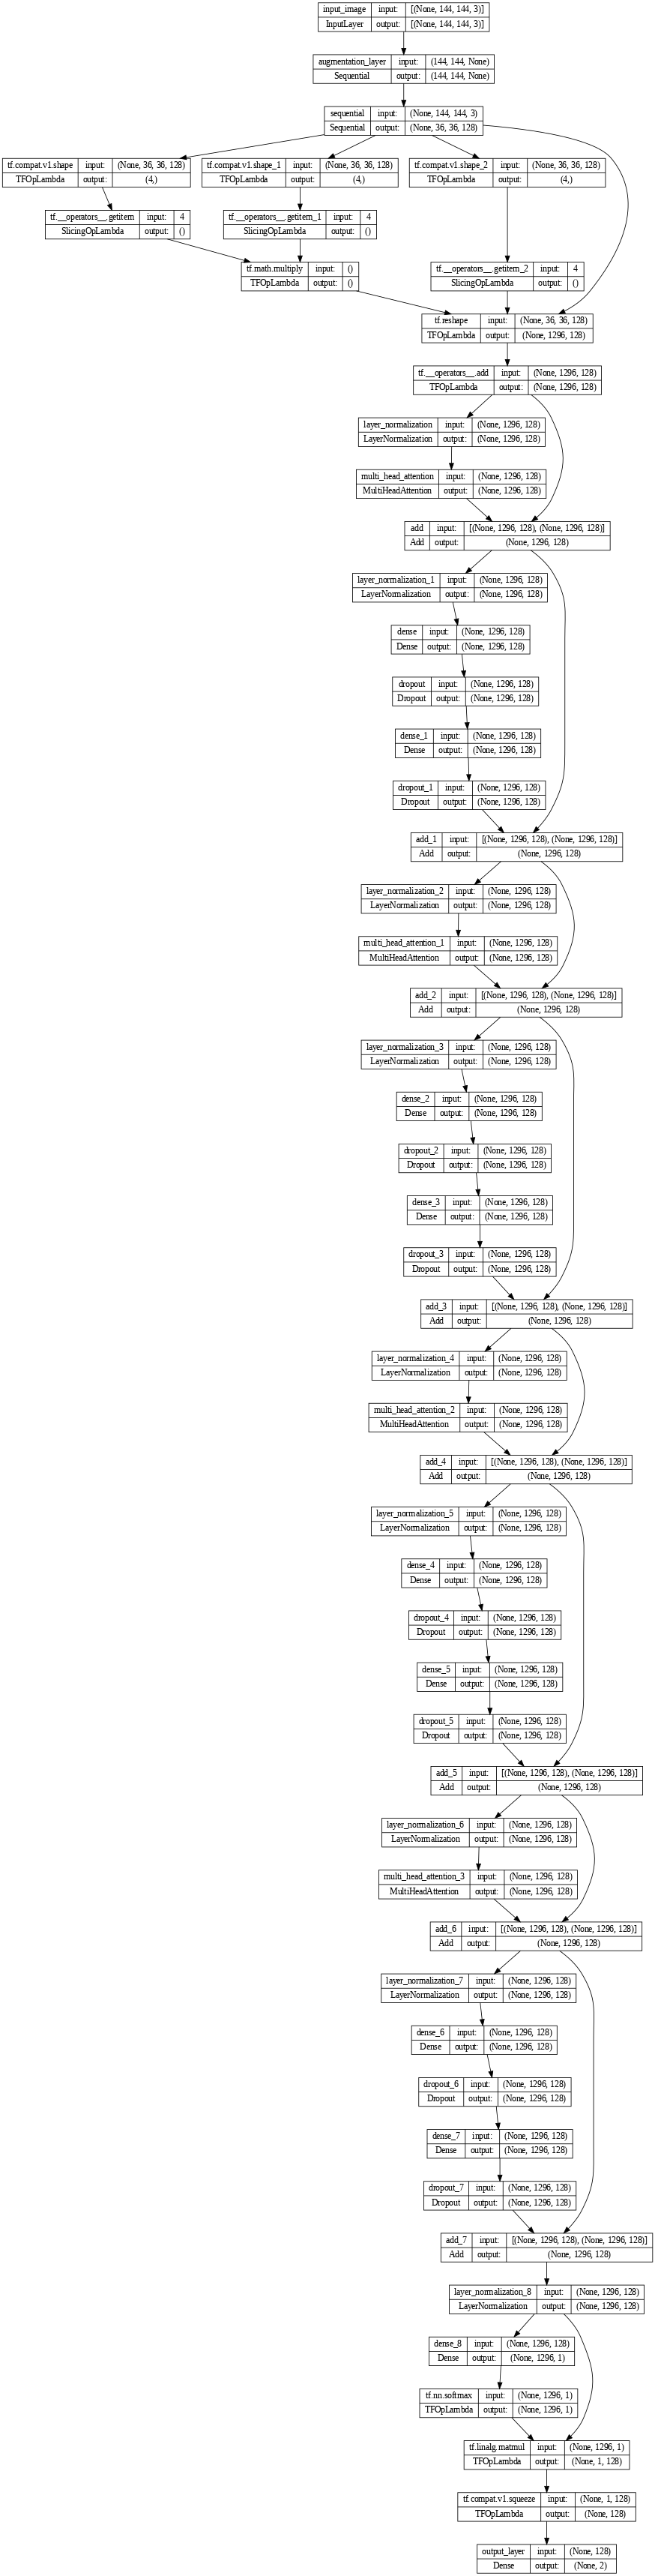

In [ ]:
# Explore model visually
plot_model(
    cct_model, dpi=60,
    show_shapes=True
)

In [ ]:
# Define Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True)

# (Optional) Define Reduce Learning Rate Callback
# reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     patience=6,
#     factor=0.1,
#     verbose=1)

# Define Callbacks and Metrics lists
CALLBACKS = [
    early_stopping_callback,
#     reduce_lr_callback
]

METRICS = ['accuracy']

In [ ]:
tf.random.set_seed(CFG.TF_SEED)

# Compile the model
cct_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    optimizer=tf.optimizers.AdamW(learning_rate=CFG.LEARNING_RATE, weight_decay=CFG.WEIGHT_DECAY),
    metrics=METRICS
)

# Train the model
print(f'Training {cct_model.name}.')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

cct_model_history = cct_model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=CFG.BATCH_SIZE,
    epochs=CFG.EPOCHS,
    callbacks=CALLBACKS,
)

Training compact_convolutional_transformer_model.
Train on 2241 samples, validate on 396 samples.
----------------------------------
Epoch 1/10
36/36 [==============================] - 74s 2s/step - loss: 0.7640 - accuracy: 0.5489 - val_loss: 0.7290 - val_accuracy: 0.5455
Epoch 2/10
36/36 [==============================] - 52s 1s/step - loss: 0.6025 - accuracy: 0.7135 - val_loss: 0.5302 - val_accuracy: 0.7576
Epoch 3/10
36/36 [==============================] - 52s 1s/step - loss: 0.5103 - accuracy: 0.7796 - val_loss: 0.5189 - val_accuracy: 0.7753
Epoch 4/10
36/36 [==============================] - 52s 1s/step - loss: 0.4860 - accuracy: 0.7974 - val_loss: 0.5057 - val_accuracy: 0.7677
Epoch 5/10
36/36 [==============================] - 52s 1s/step - loss: 0.4850 - accuracy: 0.8019 - val_loss: 0.5164 - val_accuracy: 0.7576
Epoch 6/10
36/36 [==============================] - 51s 1s/step - loss: 0.4833 - accuracy: 0.8010 - val_loss: 0.5066 - val_accuracy: 0.7626
Epoch 7/10
36/36 [=========

In [ ]:
# Evaluate the model
cct_evaluation = cct_model.evaluate(test_ds)

11/11 [==============================] - 6s 482ms/step - loss: 0.4545 - accuracy: 0.8106


In [ ]:
# Generate model probabilities and associated predictions
cct_test_probabilities = cct_model.predict(test_ds, verbose=1)
cct_test_predictions = tf.argmax(cct_test_probabilities, axis=1)

11/11 [==============================] - 5s 359ms/step


In [ ]:
def plot_training_curves(history, ):

    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o', color='C5')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o', color='C6')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C5', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C6', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend(fontsize=12);

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o', color='C5')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o', color='C6')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C5', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C6', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend(fontsize=12);

    sns.despine();

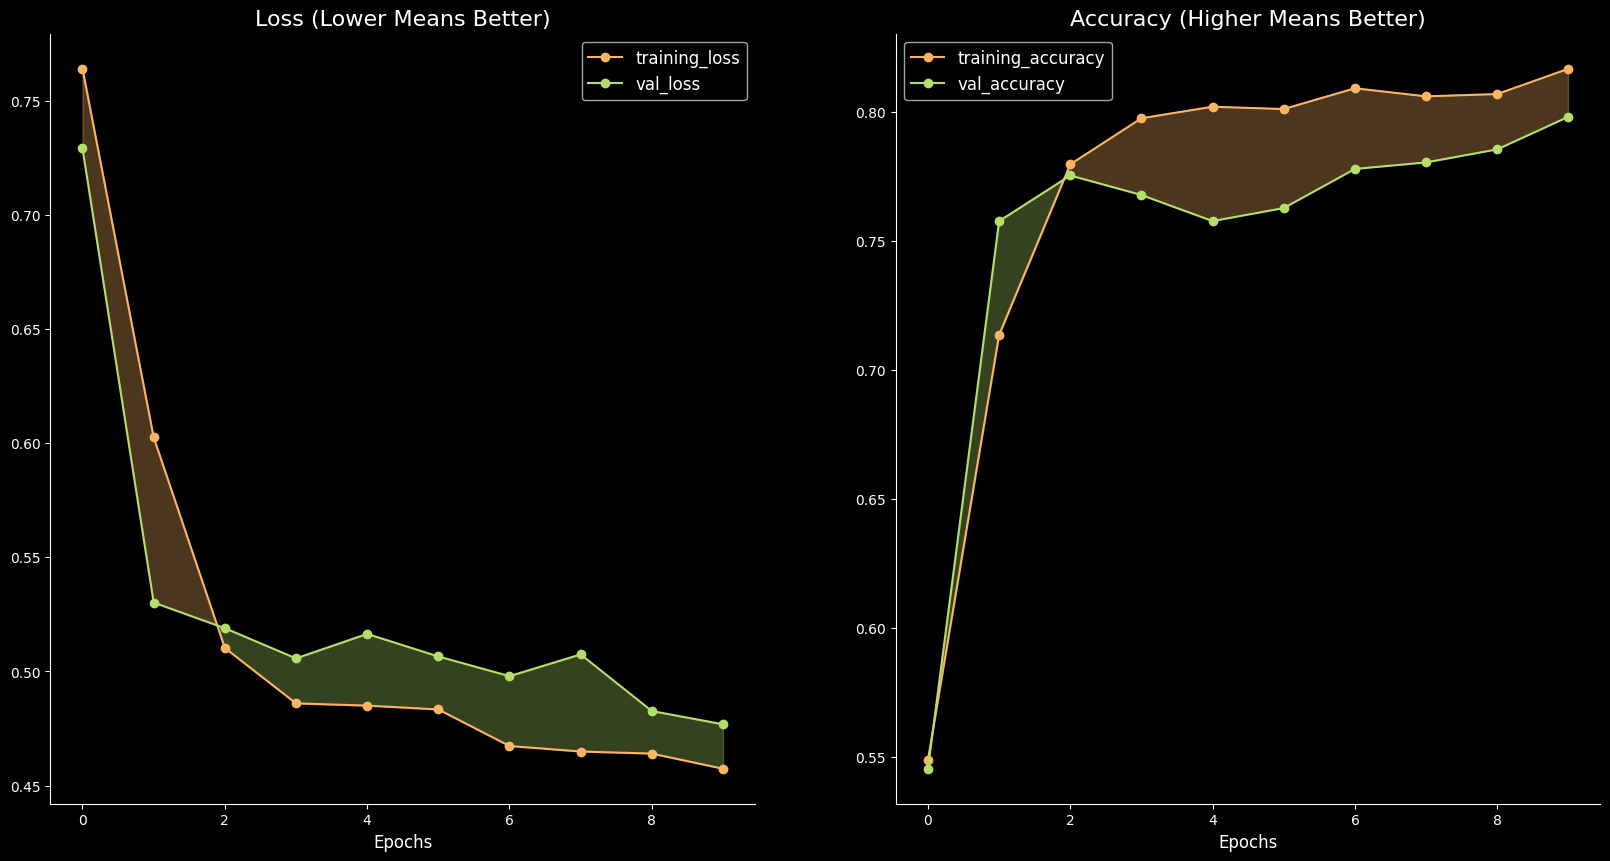

In [ ]:
# plot cct model training history
plot_training_curves(cct_model_history)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)

    # Plot confusion matrix
    plt.show()

    return

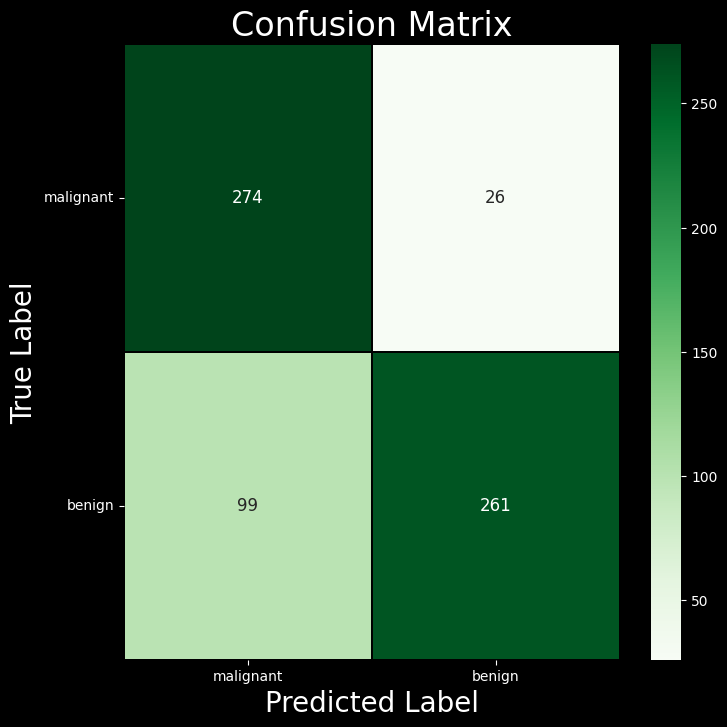

In [ ]:
class_names = ['malignant', 'benign']

plot_confusion_matrix(
    test_df.label_encoded,
    cct_test_predictions,
    figsize=(8, 8),
    classes=class_names
)

In [ ]:
class_names

['malignant', 'benign']

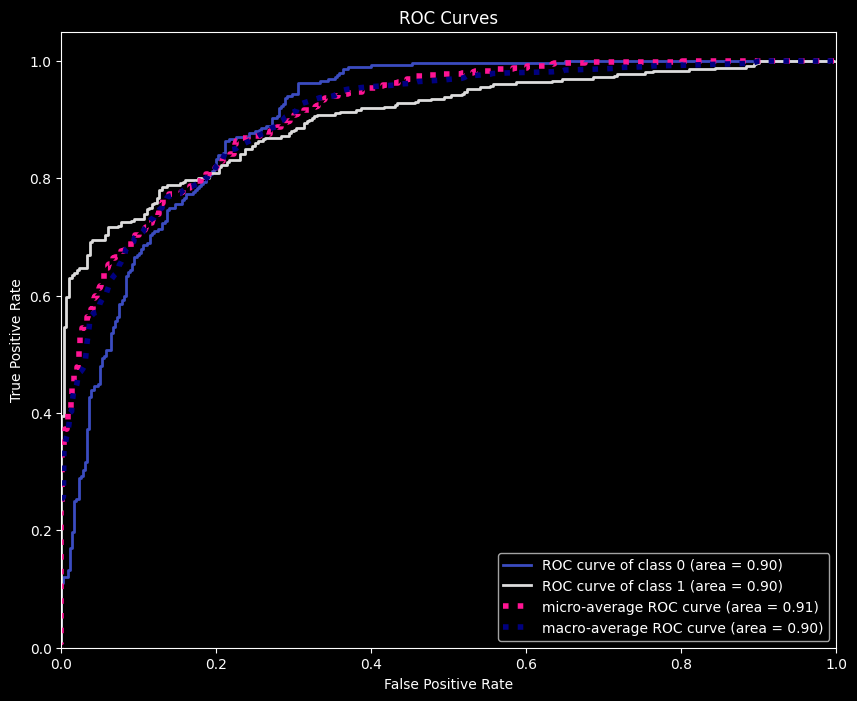

In [ ]:
plot_roc(
    test_df.label_encoded,
    cct_test_probabilities,
    figsize=(10, 8),
    title_fontsize='large',
    cmap='coolwarm'
);

In [ ]:
print(classification_report(
    test_df.label_encoded,
    cct_test_predictions,
    target_names=class_names
))

              precision    recall  f1-score   support

   malignant       0.73      0.91      0.81       300
      benign       0.91      0.72      0.81       360

    accuracy                           0.81       660
   macro avg       0.82      0.82      0.81       660
weighted avg       0.83      0.81      0.81       660



In [ ]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):

    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                 y_pred,
                                                                                 average="weighted")
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)

    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')

    preformance_scores = {
        'accuracy_score': model_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'f1_score': model_f1,
        'matthews_corrcoef': model_matthews_corrcoef
    }
    return preformance_scores

In [ ]:
# Record CCT model performance scores
cct_performance = generate_preformance_scores(
    test_df.label_encoded,
    cct_test_predictions,
    cct_test_probabilities
)


Performance Metrics:

accuracy_score:		0.8106

_____________________________________________
precision_score:	0.8299

_____________________________________________
recall_score:		0.8106

_____________________________________________
f1_score:		0.8102

_____________________________________________
matthews_corrcoef:	0.6412



In [ ]:
test_df

image_path      label  \
0    /content/input/skin-cancer-malignant-vs-benign...  malignant   
1    /content/input/skin-cancer-malignant-vs-benign...  malignant   
2    /content/input/skin-cancer-malignant-vs-benign...     benign   
3    /content/input/skin-cancer-malignant-vs-benign...  malignant   
4    /content/input/skin-cancer-malignant-vs-benign...     benign   
..                                                 ...        ...   
655  /content/input/skin-cancer-malignant-vs-benign...     benign   
656  /content/input/skin-cancer-malignant-vs-benign...     benign   
657  /content/input/skin-cancer-malignant-vs-benign...     benign   
658  /content/input/skin-cancer-malignant-vs-benign...  malignant   
659  /content/input/skin-cancer-malignant-vs-benign...     benign   

     label_encoded  
0                0  
1                0  
2                1  
3                0  
4                1  
..             ...  
655              1  
656              1  
657              1  
658              0  
659              1  

[660 rows x 3 columns]

In [ ]:
def view_multiple_predictions(df, model, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1

    idx = random.sample(df.index.to_list(), count)
    fig = plt.figure(figsize=fig_size)

    # Setup useful dictionaries
    label_set = {0: 'malignant', 1: 'benign'}
    color_set = {False: 'red', True: 'green'}

    for column, _ in enumerate(idx):

        # Predict label
        img = sample_loader(df.image_path[_])
        probability = np.squeeze(
            model.predict(np.array([img]), verbose=0)
        )
        prediction = np.argmax(probability)

        # Validate prediction correctness
        correct_prediction = (prediction == df.label_encoded[_])

        # Setup subplot & title
        ax = plt.subplot(rows, 5, column+1)
        ax.set_title(
            f'Actual Label: {df.label[_]}',
            pad=20,
            fontsize=14,
            color=color_set[correct_prediction]
        )

        # Plot image
        if color_map=='rgb':
            ax.imshow(img)
        else:
            ax.imshow(tf.image.rgb_to_grayscale(img), cmap=color_map)

        ax.set_xticks([])
        ax.set_yticks([])

        # Plot prediction  & probability
        txt = f'Prediction: {label_set[prediction]}\nProbability: {(100 * probability[prediction]):.2f}%'
        plt.xlabel(txt, fontsize=14, color=color_set[correct_prediction])

    return

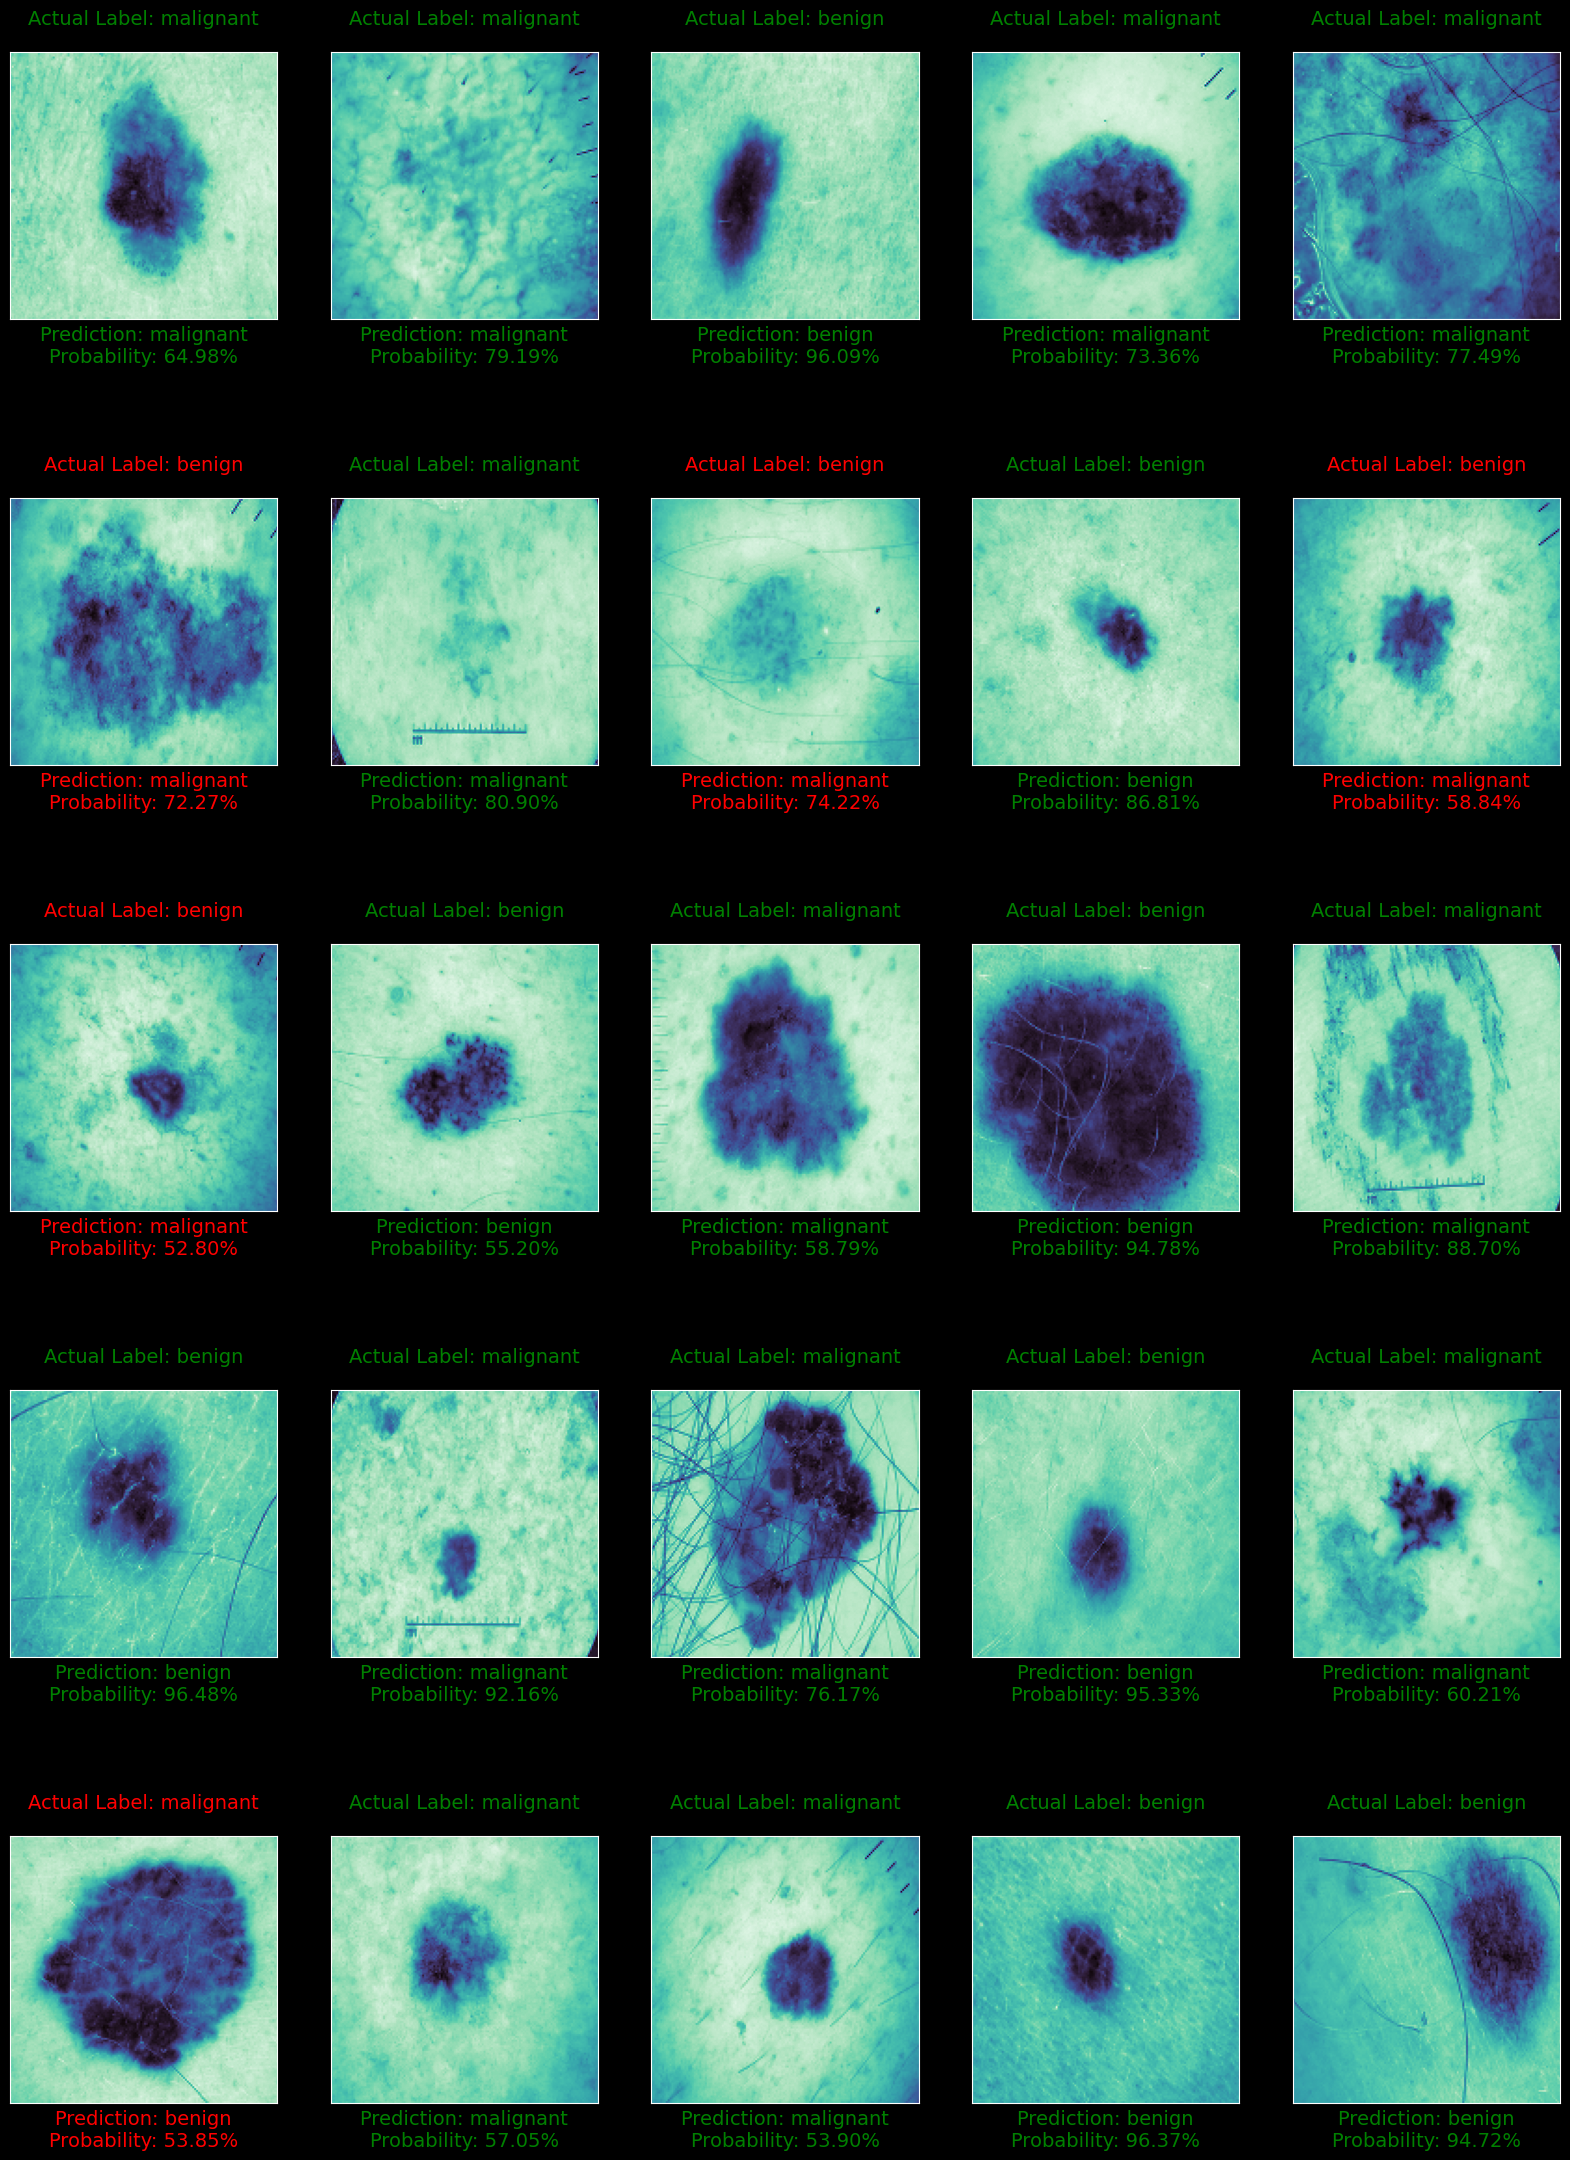

In [ ]:
view_multiple_predictions(
    test_df,
    cct_model,
    _load,
    count=25,
    color_map='mako',
    fig_size=(20, 28)
)